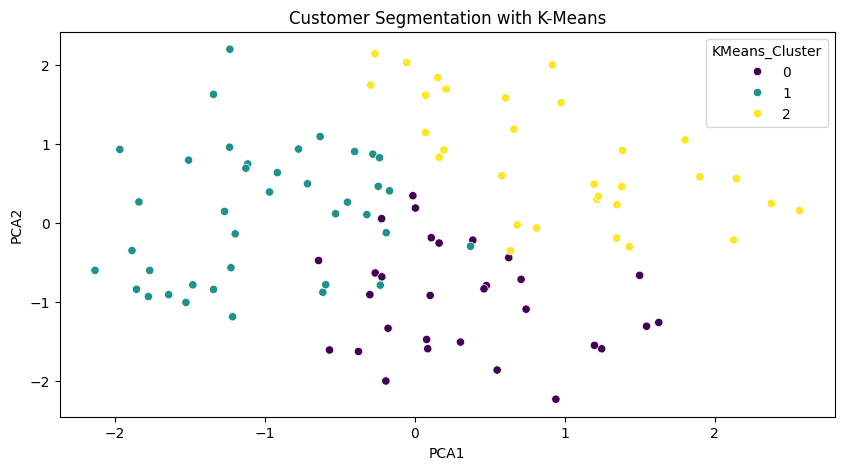

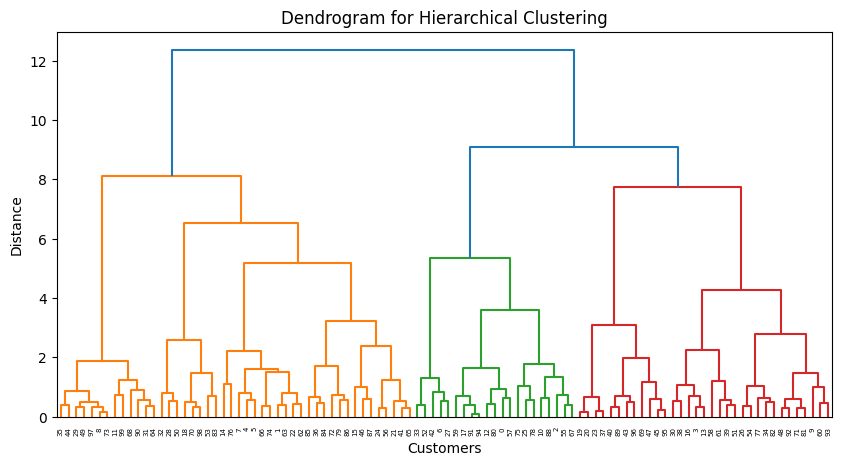

 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on all addresses (0.0.0.0)
 * Running on http://127.0.0.1:5000
 * Running on http://172.28.0.12:5000
INFO:werkzeug:Press CTRL+C to quit


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import dendrogram, linkage
import joblib
from flask import Flask, request, jsonify

# Generate a small synthetic dataset with 100 records
data = {
    'CustomerID': range(1, 101),
    'Annual_Income': np.random.randint(15000, 90000, 100),
    'Spending_Score': np.random.randint(1, 100, 100),
    'Savings_Balance': np.random.randint(1000, 50000, 100)
}
df = pd.DataFrame(data)
df.set_index('CustomerID', inplace=True)

# Standardize data
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df)

# Apply K-Means Clustering
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
df['KMeans_Cluster'] = kmeans.fit_predict(df_scaled)

# Apply Hierarchical Clustering
hierarchical = AgglomerativeClustering(n_clusters=3)
df['Hierarchical_Cluster'] = hierarchical.fit_predict(df_scaled)

# Save the models
joblib.dump(kmeans, 'kmeans_model.pkl')
joblib.dump(scaler, 'scaler.pkl')

# Visualize clusters using PCA
pca = PCA(n_components=2)
df_pca = pca.fit_transform(df_scaled)
df['PCA1'] = df_pca[:, 0]
df['PCA2'] = df_pca[:, 1]

plt.figure(figsize=(10,5))
sns.scatterplot(x=df['PCA1'], y=df['PCA2'], hue=df['KMeans_Cluster'], palette='viridis')
plt.title("Customer Segmentation with K-Means")
plt.show()

# Plot Dendrogram for Hierarchical Clustering
plt.figure(figsize=(10,5))
linkage_matrix = linkage(df_scaled, method='ward')
dendrogram(linkage_matrix)
plt.title("Dendrogram for Hierarchical Clustering")
plt.xlabel("Customers")
plt.ylabel("Distance")
plt.show()

# Flask App for Deployment
app = Flask(__name__)

@app.route('/predict', methods=['POST'])
def predict():
    data = request.get_json()
    features = np.array(data['features']).reshape(1, -1)
    scaler = joblib.load('scaler.pkl')
    kmeans = joblib.load('kmeans_model.pkl')
    features_scaled = scaler.transform(features)
    prediction = kmeans.predict(features_scaled)
    return jsonify({'Cluster': int(prediction[0])})

if __name__ == '__main__':
    app.run(host='0.0.0.0', port=5000, debug=False)
